## Song Embeddings - Skipgram Recommender

In this notebook, we'll use human-made music playlists to learn song embeddings. We'll treat a playlist as if it's a sentence and the songs it contains as words. We feed that to the word2vec algorithm which then learns embeddings for every song we have. These embeddings can then be used to recommend similar songs. This technique is used by Spotify, AirBnB, Alibaba, and others. It accounts for a vast portion of their user activity, user media consumption, and/or sales (in the case of Alibaba).

The [dataset we'll use](https://www.cs.cornell.edu/~shuochen/lme/data_page.html) was collected by Shuo Chen from Cornell University. The dataset contains playlists from hundreds of radio stations from around the US.

## Importing packages and dataset

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from urllib import request
import warnings
warnings.filterwarnings('ignore')

import gensim
import gensim.downloader as api
import matplotlib.pyplot as plt #to generate the t-SNE plot
from sklearn.manifold import TSNE #scikit learn's TSNE
import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine

The playlist dataset is a text file where every line represents a playlist. That playlist is basically a series of song IDs.

In [2]:
# Get the playlist dataset file
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

# Parse the playlist dataset file. Skip the first two lines as
# they only contain metadata
lines = data.read().decode("utf-8").split('\n')[2:]

# Remove playlists with only one song
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]


The `playlists` variable now contains a python list. Each item in this list is a playlist containing song ids. We can look at the first two playlists here:

In [3]:
print( 'Playlist #1:\n ', playlists[0], '\n')
print( 'Playlist #2:\n ', playlists[1])

Playlist #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

Playlist #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117',

## Training the Word2Vec Model
Our dataset is now in the shape the the Word2Vec model expects as input. We pass the dataset to the model.

In [4]:
model = Word2Vec(playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4)

The model is now trained. Every song has an embedding. We only have song IDs, though, no titles or other info. Let's grab the song information file.

In [5]:
primer_palabra = list(model.wv.key_to_index.keys())[0]
segunda_palabra = list(model.wv.key_to_index.keys())[1]
# Obtener el vector asociado a la primera palabra del vocabulario
vector_primer_palabra = model.wv[primer_palabra]
vector_segunda_palabra = model.wv[segunda_palabra]
print("Palabra:", primer_palabra)
print("Vector asociado:", vector_primer_palabra, '\n')

print("Palabra:", segunda_palabra)
print("Vector asociado:", vector_segunda_palabra)

Palabra: 20065
Vector asociado: [-3.923814   -0.6707036   2.0714815   1.2290156  -0.8728275  -6.6694965
 -2.919169   -1.3539416  -4.52668    -1.368272   -1.1563814  -0.5883677
  5.7019663  -1.413259    3.914417    0.52472687  0.7574985  -0.3373883
  1.4788048  -0.12636395  1.4891577  -0.11457334 -2.9090974   3.029779
  0.93945736  2.6143808   4.3258653   2.4963646   1.4628683   3.6337895
  2.2208738  -0.6138651 ] 

Palabra: 5
Vector asociado: [-2.995328   -0.61282104  2.0729399   1.2503076  -0.5995422  -5.1881127
 -2.1815784  -1.1616337  -3.8492277  -0.64855313 -0.77115524 -0.4345969
  4.705726   -1.48832     3.3733935   0.526416    0.6131815  -0.18812947
  1.2814192   0.50833076  1.0313847  -0.09840393 -2.057174    2.1393514
  0.36738667  1.6094317   3.5841238   1.9496477   1.4037513   3.0327733
  2.0275912  -0.5797305 ]


In [6]:
#Similitud de coseno entre las dos primeras
similitud_cos = 1 - cosine(vector_primer_palabra, vector_segunda_palabra)

print(similitud_cos)

0.9934424161911011


## Song Title and Artist File
Let's load and parse the file containing song titles and artists

In [7]:
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode("utf-8").split('\n')
songs = [s.rstrip().split('\t') for s in songs_file]

In [8]:
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

In [9]:
songs_df.head()

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


### Exercise:

Build visualization for the embeddings of the song recommender.

In [10]:
# Ver las dimensiones del DataFrame antes del filtro
print("Dimensiones del DataFrame antes del filtro:", songs_df.shape)

# Limpiar caracteres no deseados y espacios en blanco de los índices del DataFrame
songs_df.index = songs_df.index.str.strip().str.replace('[^a-zA-Z0-9]', '')

# Obtener los índices válidos que están presentes en el DataFrame original
valid_indexes = [index for index in songs_df.index if index in model.wv.key_to_index]

# Filtrar el DataFrame original usando los índices válidos
filtered_songs_df = songs_df[songs_df.index.isin(valid_indexes)]

# Obtener las dimensiones del DataFrame después del filtro
print("Dimensiones del DataFrame después del filtro:", filtered_songs_df.shape)

Dimensiones del DataFrame antes del filtro: (75263, 2)
Dimensiones del DataFrame después del filtro: (75261, 2)


In [11]:
# Obtener los vectores de palabras correspondientes a las canciones del DataFrame limpio
song_embeddings = [model.wv[word] for word in filtered_songs_df.index]

# Convertir la lista de embeddings de canciones a una matriz NumPy
song_embeddings_array = np.array(song_embeddings)

In [12]:
# Aplicar t-SNE para reducir la dimensionalidad de los vectores de palabras a 2D
tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(song_embeddings_array)

# Crear un DataFrame para los resultados de t-SNE
tsne_df = pd.DataFrame(data=new_values, columns=['tsne_x', 'tsne_y'], index=filtered_songs_df.index)

KeyboardInterrupt: 

In [12]:
filtered_songs_df.head()

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


In [13]:
song_id = 2172

# Ask the model for songs similar to song #2172
model.wv.most_similar(positive=str(song_id))

[('3167', 0.9976319670677185),
 ('11473', 0.9974431991577148),
 ('2640', 0.9967246055603027),
 ('5634', 0.9962242245674133),
 ('1922', 0.9961997270584106),
 ('2849', 0.9961106181144714),
 ('5549', 0.996067225933075),
 ('2014', 0.994943380355835),
 ('2976', 0.9944005608558655),
 ('2063', 0.9943320155143738)]

In [14]:
filtered_songs_df.iloc[2172]

title     Fade To Black
artist        Metallica
Name: 2172, dtype: object

In [15]:
similar_songs = np.array(model.wv.most_similar(positive=str(song_id)))[:,0]
songs_df.iloc[similar_songs]

,title,artist
id,,
3167,Unchained,Van Halen
11473,Little Guitars,Van Halen
2640,Red Barchetta,Rush
5634,Mr. Brownstone,Guns N' Roses
1922,One,Metallica
2849,Run To The Hills,Iron Maiden
5549,November Rain,Guns N' Roses
2014,Youth Gone Wild,Skid Row
2976,I Don't Know,Ozzy Osbourne


In [16]:
def print_recommendations(song_id):
    song_id_str = str(song_id)
    print(songs_df.loc[song_id_str])
    similar_songs = np.array(model.wv.most_similar(positive=[song_id_str]))[:, 0]
    return songs_df.iloc[similar_songs]

In [17]:
print_recommendations(19563)

title     Paranoid Android
artist           Radiohead
Name: 19563, dtype: object


,title,artist
id,,
44542,-,-
24397,Cameras,Matt And Kim
48852,Brimful Of Asha,Cornershop
1740,Lights,Interpol
40245,Gold Gun Girls,Metric
24752,The Denial Twist,The White Stripes
38877,No New Tale To Tell,Love And Rockets
22812,Phantom Limb,The Shins
32649,Teenage Lobotomy,The Ramones


In [18]:
print_recommendations(22599)

title             Young Folks
artist    Peter, Bjorn & John
Name: 22599, dtype: object


,title,artist
id,,
12891,Month Of May,Arcade Fire
19732,Everlasting Light,The Black Keys
40245,Gold Gun Girls,Metric
40381,Clampdown,The Clash
22812,Phantom Limb,The Shins
30215,Hang Me Up To Dry,Cold War Kids
30082,A Message To You Rudy,The Specials
15882,Fortress,Pinback
2050,Natural One,The Folk Implosion


In [19]:
keys = ['22599', '12345', '67890']
embedding_clusters2 = []  
word_clusters2 = []  

for word in keys:
    embeddings2 = []
    words2 = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):  # Accediendo a wv antes de most_similar
        words2.append(similar_word)
        embeddings2.append(model.wv[similar_word])  # Accediendo a wv antes de model
    embedding_clusters2.append(embeddings2)
    word_clusters2.append(words2)
    


In [20]:
print("Embedding clusters:",embedding_clusters2[0][0])#Access vector of the first word only
print("Word Clousters:",word_clusters2[:2])

Embedding clusters: [-1.5047194  -0.9586088   1.5696522   1.0659659   0.17457896 -0.7074574
 -1.080252   -0.05912421 -1.3865403   1.0076851   0.13034326  0.63954705
  0.55568117 -1.4869505   0.8314448  -0.04317227 -0.00959377  1.4055562
  0.21222429  1.0594748   0.20501891  0.7279389  -0.00354863  0.6260593
 -1.1781505   0.33551255 -0.08898628 -0.0345595   0.58598864  0.86934894
  1.9031483  -0.2594889 ]
Word Clousters: [['12891', '19732', '40245', '40381', '22812', '30215', '30082', '15882', '2050', '38757', '41687', '16378', '38877', '1740', '41690', '4514', '38601', '24397', '10146', '19563', '32649', '44542', '22775', '29922', '34196', '22904', '22814', '33295', '40382', '19207'], ['18838', '18628', '5326', '52598', '24263', '34181', '18483', '15719', '27472', '1605', '7370', '40197', '15583', '1575', '40499', '12486', '7304', '11913', '3168', '3172', '3194', '8619', '18898', '3200', '16037', '33056', '7', '34355', '6857', '14646']]


In [21]:
embedding_clusters2 = np.array(embedding_clusters2)
n, m, k = embedding_clusters2.shape #geting the dimensions
tsne_model_en_2d = TSNE(perplexity=5, n_components=2, init='pca', n_iter=1500, random_state=2020)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters2.reshape(n * m, k))).reshape(n, m, 2) #reshaping it into 2d so we can visualize it

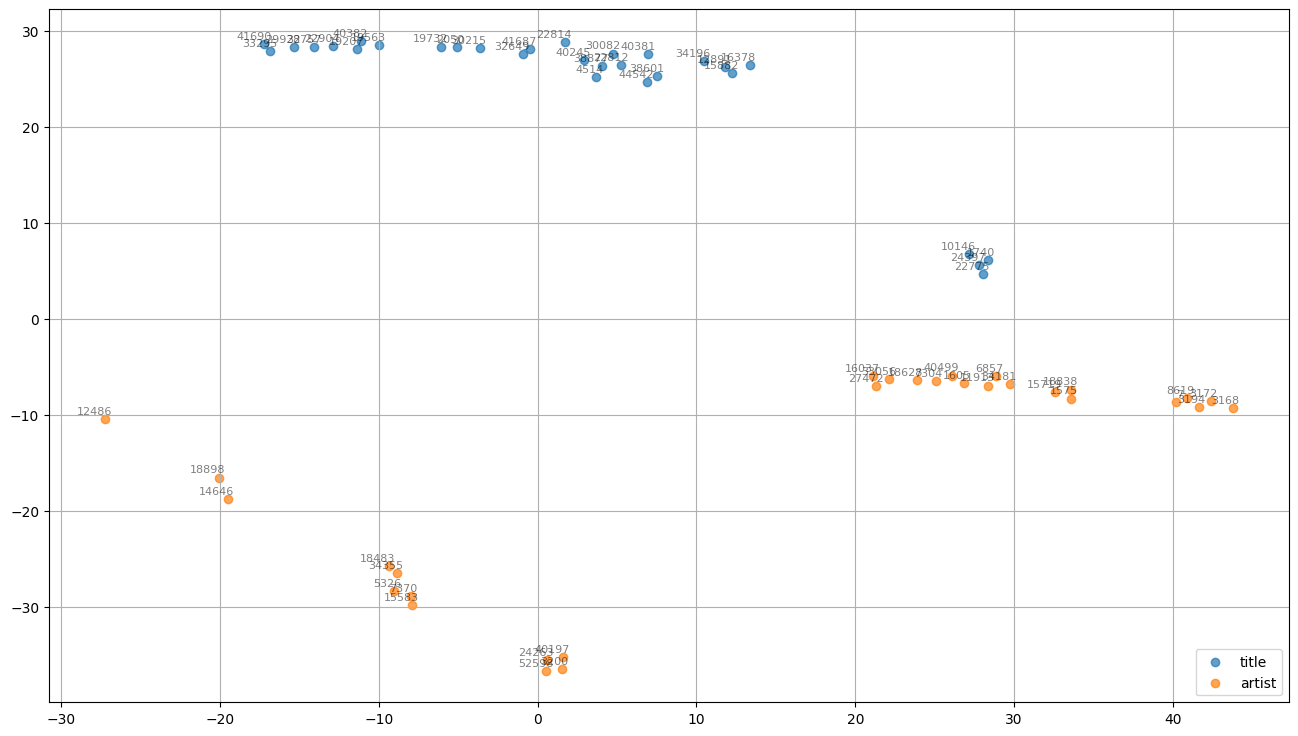

In [23]:
#script for constructing two-dimensional graphics using Matplotlib
def tsne_plot_similar_words(labels, embedding_clusters2, word_clusters2, a=0.7):
    plt.figure(figsize=(16, 9))


    for label, embeddings2, words2 in zip(labels, embedding_clusters2, word_clusters2):
        x = embeddings2[:,0]
        y = embeddings2[:,1]
        plt.scatter(x, y, alpha=a, label=label)
        for i, word in enumerate(words2):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words(filtered_songs_df, embeddings_en_2d, word_clusters2)

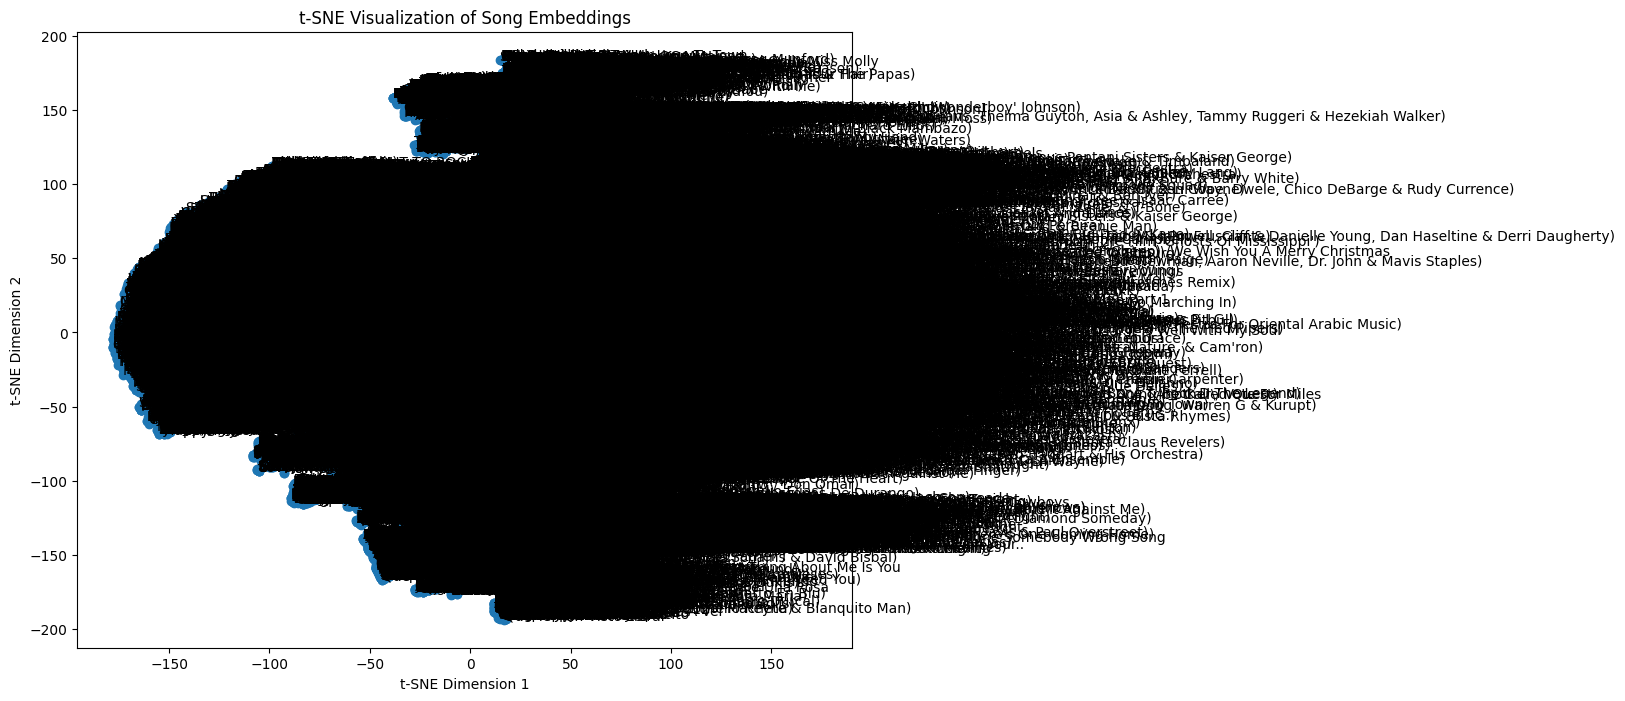

In [13]:
# Obtener los vectores de palabras correspondientes a las canciones del DataFrame limpio
#song_embeddings = [model.wv[word] for word in filtered_songs_df.index]

# Aplicar t-SNE para reducir la dimensionalidad de los vectores de palabras a 2D
#tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
#new_values = tsne_model.fit_transform(song_embeddings)

# Crear un DataFrame para los resultados de t-SNE
#tsne_df = pd.DataFrame(data=new_values, columns=['tsne_x', 'tsne_y'], index=filtered_songs_df.index)

# Combinar el DataFrame de canciones con el DataFrame de t-SNE
songs_with_tsne = pd.concat([filtered_songs_df, tsne_df], axis=1)

# Graficar los resultados de t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(songs_with_tsne['tsne_x'], songs_with_tsne['tsne_y'])
plt.title('t-SNE Visualization of Song Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
for index, row in songs_with_tsne.iterrows():
    plt.annotate(row['title'], (row['tsne_x'], row['tsne_y']))
plt.show()